In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
from art.defences.trainer import AdversarialTrainer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from art.attacks.evasion import (
    FastGradientMethod,
    BasicIterativeMethod,
    ProjectedGradientDescent
)
import shap

import scipy.special
import matplotlib.pyplot as plt

/Users/thomas/Vault/01 Development/University/p2p-credit-risk/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/thomas/Vault/01 Development/University/p2p-credit-risk/.venv/lib/python3.12/site-packages/art/estimators/certification/__init__.py:30: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [2]:
# Load Data
data_dir = 'ml/StandardScalerOneHotEncoder'
X_train = pd.read_csv(os.path.join(data_dir, 'X_train.csv')).values
y_train = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))['is_default'].values
X_val   = pd.read_csv(os.path.join(data_dir, 'X_val.csv')).values
y_val   = pd.read_csv(os.path.join(data_dir, 'y_val.csv'))['is_default'].values
X_test  = pd.read_csv(os.path.join(data_dir, 'X_test.csv')).values
y_test  = pd.read_csv(os.path.join(data_dir, 'y_test.csv'))['is_default'].values
X_test_SHAP = pd.read_csv(os.path.join(data_dir, 'X_test.csv'))

### Model Creation Function

-   **Architecture**: A `Sequential` model, which is a linear stack of layers.
    -   It contains two hidden `Dense` (fully-connected) layers with 128 and 64 units respectively.
    -   Each hidden layer uses the **`relu`** (Rectified Linear Unit) activation function. ReLU is chosen for its computational efficiency and its effectiveness in mitigating the vanishing gradient problem in deeper networks.

-   **Regularization**: `Dropout` is used as a regularization technique to prevent overfitting.
    -   `Dropout(0.3)` randomly sets 30% of the input units to 0 at each update during training. This prevents neurons from co-adapting too much and forces the model to learn more robust features.

-   **Output Layer**: The final layer is configured for classification.
    -   It is a `Dense` layer with 2 units, corresponding to the two output classes (defaulted vs not defaulted)
    -   It uses the **`softmax`** activation function, which converts the raw output into a probability distribution. The output vector's components sum to 1, representing the model's predicted probability for each class.

-   **Compiler**: This step configures the model's learning process.
    -   **Optimizer (`adam`)**: The model uses the Adam (Adaptive Moment Estimation) optimizer. It's an efficient stochastic gradient descent algorithm that computes adaptive learning rates for each parameter by storing an exponentially decaying average of past squared gradients (like RMSprop) and past gradients (like momentum). It is a robust and widely used default optimizer.
    -   **Loss Function (`sparse_categorical_crossentropy`)**: The loss function measures the divergence between the true and predicted probability distributions. The `sparse` version of categorical crossentropy is used here because the ground-truth labels are provided as integers (e.g., `0`, `1`), not as one-hot encoded vectors.
   
The Dense layer and Dropout rates are common starting points, not chosen through experimentation.

In [3]:
def create_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

### Training Configuration Parameters

-   **`epochs=50`**: An **epoch** is one complete forward and backward pass of the entire training dataset. Setting this to 50 establishes the *maximum* number of training cycles. In practice, the training will likely end sooner due to the `EarlyStopping` callback.

-   **`batch_size=256`**: The training data is not processed all at once. Instead, it is broken down into smaller subsets called **batches**. The model's internal weights are updated after processing each batch. This method, mini-batch gradient descent, is more memory-efficient and often leads to faster convergence and better generalization than processing the entire dataset in one go. A batch size of 256 is a common choice, as powers of two can optimize memory allocation on GPUs.

-   **`callbacks=[tf.keras.callbacks.EarlyStopping(...)]`**: **Callbacks** are objects that can perform actions at various stages of training, such as at the end of an epoch. They are used here to implement a crucial control mechanism.
    -   **`EarlyStopping`**: This callback is a form of regularization that prevents **overfitting** by halting the training process once the model's performance stops improving on a validation set.
        -   `monitor='val_loss'`: The specific metric being monitored is the loss calculated on the validation data (`X_val`, `y_val`). This is the most important indicator of how well the model generalizes to unseen data. If this value stops decreasing, the model is no longer learning useful patterns.
        -   `patience=5`: This parameter defines the number of epochs to wait for an improvement before stopping. A `patience` of 5 allows the training to continue for 5 epochs even if `val_loss` is not improving, which helps to avoid stopping prematurely due to random fluctuations in the validation loss.

In [4]:
# Train the Baseline Model
input_dim = X_train.shape[1]
baseline_model = create_model(input_dim)
baseline_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=256,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    verbose=0
)

In [5]:
# Evaluate Baseline Model on CLEAN Data
baseline_preds_clean_probs = baseline_model.predict(X_test, verbose=0)[:, 1]
baseline_preds_clean_labels = (baseline_preds_clean_probs >= 0.5).astype(int)

auc_baseline_clean = roc_auc_score(y_test, baseline_preds_clean_probs)
acc_baseline_clean = accuracy_score(y_test, baseline_preds_clean_labels)

print(f"AUC on clean data: {auc_baseline_clean:.4f}")
print(f"Accuracy on clean data: {acc_baseline_clean:.4f}")

AUC on clean data: 0.6941
Accuracy on clean data: 0.6464


In [6]:
# Load feature names
data_dir = 'ml/StandardScalerOneHotEncoder'
df = pd.read_csv(os.path.join(data_dir, 'X_train.csv'))
feature_names = df.columns.tolist()
# Subset X_test for SHAP on 1000 samples
X_test_subset = X_test_SHAP[:1000]

# Initialize SHAP Explaine
explainer = shap.Explainer(baseline_model, X_test_subset)

# 2Explain the raw output
shap_values_baseline = explainer(X_test_subset)

print(shap_values_baseline.values.shape)





PermutationExplainer explainer: 1001it [00:20, 27.18it/s]                         

(1000, 102, 2)


/var/folders/_r/jrbky9rn14scnq_kz278z9dw0000gn/T/ipykernel_28107/2827193529.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


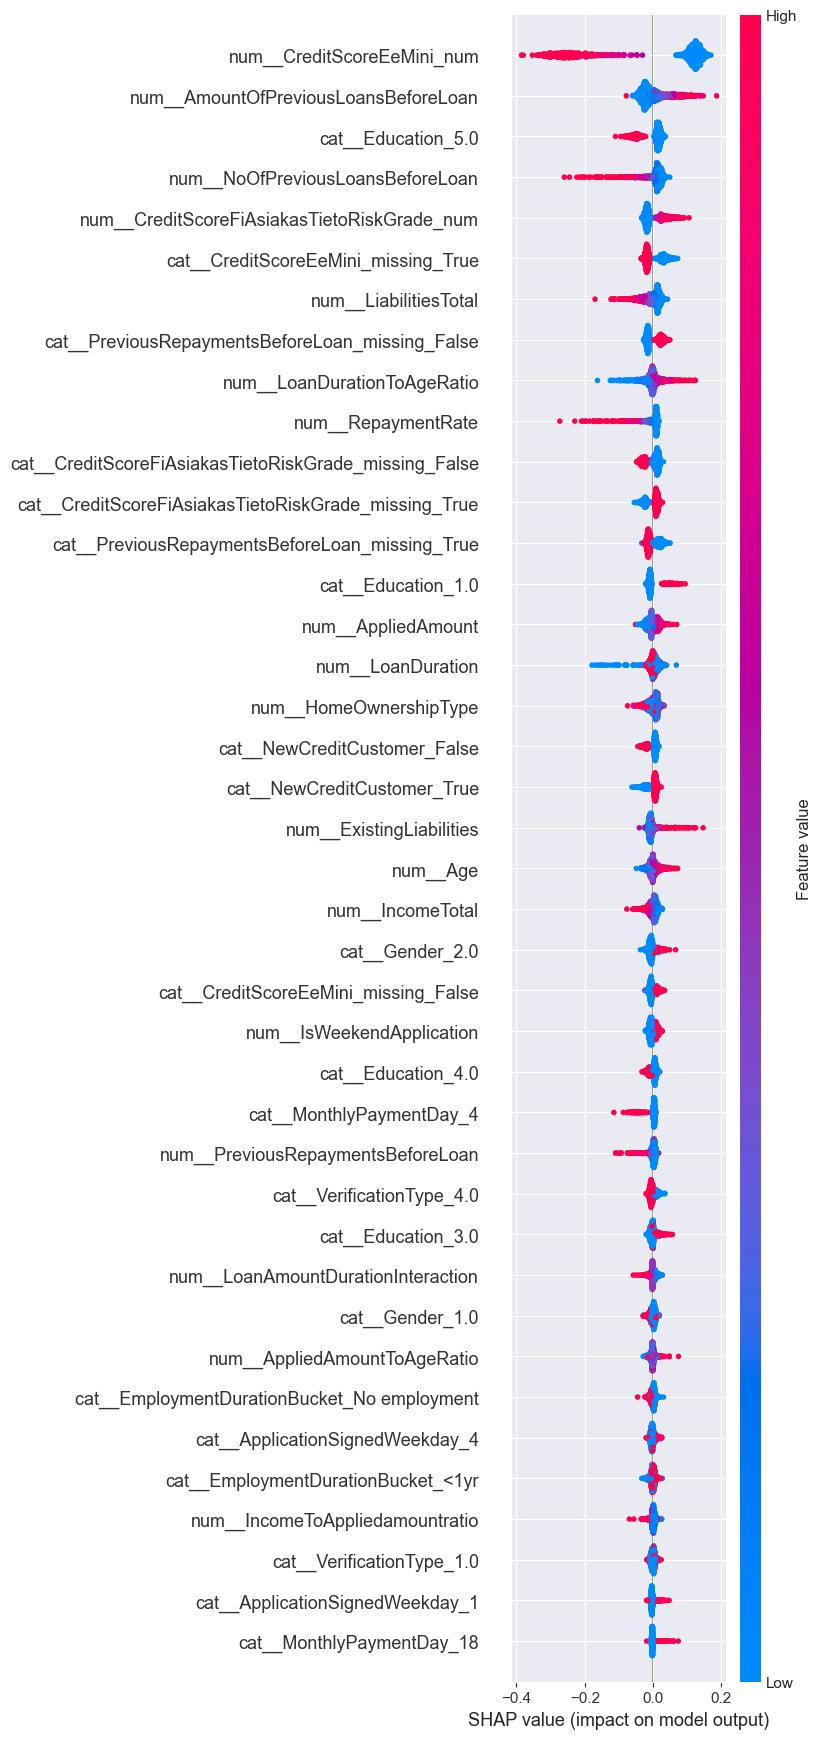

In [7]:
# Plot SHAP Summary Plot on top 40 features
shap.summary_plot(
    shap_values_baseline[:, :, 1], 
    X_test_subset, 
    feature_names=feature_names, 
    max_display=40
)

In [8]:
# Three attacks with three different Epsilons
classifier_art = TensorFlowV2Classifier(
    model=baseline_model,
    nb_classes=2,
    input_shape=(X_train.shape[1],),
    loss_object=tf.keras.losses.BinaryCrossentropy(),
    clip_values=(np.min(X_train), np.max(X_train))
)

attacks = {
    "FGSM": FastGradientMethod,
    "BIM": BasicIterativeMethod,
    "PGD": ProjectedGradientDescent
}

param_map = {
    "FGSM": lambda eps: {"eps": eps},
    "BIM":  lambda eps: {"eps": eps, "max_iter": 10},
    "PGD":  lambda eps: {"eps": eps, "eps_step": eps/5, "max_iter": 10}
}

epsilons = [0.01, 0.05, 0.1, 0.2]

results = []
for name, Attack in attacks.items():
    for eps in epsilons:
        # initialize attack
        atk = Attack(estimator=classifier_art, **param_map[name](eps))
        # generate adversarial examples
        x_adv = atk.generate(x=X_test)
        
        # sanity-check max L∞ perturbation
        linf = np.max(np.abs(x_adv - X_test))
        print(f"{name} @ ε={eps:.2f} → max |Δ|∞ = {linf:.4f}")
        
        # re-predict on the adversarial inputs!
        probs = classifier_art.predict(x_adv)  
        probs_pos = probs[:, 1]
        
        # compute metrics
        acc = accuracy_score(y_test, (probs_pos >= 0.5).astype(int))
        auc = roc_auc_score(y_test, probs_pos)
        
        results.append({
            "Attack":  name,
            "Epsilon": eps,
            "Linfty":  linf,
            "Accuracy": acc,
            "AUC":      auc
        })

df = pd.DataFrame(results)
print(df.sort_values(["Attack","Epsilon"]))  

FGSM @ ε=0.01 → max |Δ|∞ = 0.0100
FGSM @ ε=0.05 → max |Δ|∞ = 0.0500
FGSM @ ε=0.10 → max |Δ|∞ = 0.1004
FGSM @ ε=0.20 → max |Δ|∞ = 0.2000


PGD - Batches: 600it [00:17, 33.52it/s]2025-06-29 21:39:29.905823: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


BIM @ ε=0.01 → max |Δ|∞ = 0.0100


PGD - Batches: 600it [00:17, 36.80it/s]2025-06-29 21:39:49.361288: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


BIM @ ε=0.05 → max |Δ|∞ = 0.0500


BIM @ ε=0.10 → max |Δ|∞ = 0.1000


PGD - Batches: 600it [00:16, 37.14it/s]2025-06-29 21:40:25.248313: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


BIM @ ε=0.20 → max |Δ|∞ = 0.2000


PGD @ ε=0.01 → max |Δ|∞ = 0.0100


PGD @ ε=0.05 → max |Δ|∞ = 0.0500


PGD @ ε=0.10 → max |Δ|∞ = 0.1000


PGD - Batches: 600it [00:16, 36.94it/s]2025-06-29 21:41:39.137326: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


PGD @ ε=0.20 → max |Δ|∞ = 0.2000
   Attack  Epsilon    Linfty  Accuracy       AUC
4     BIM     0.01  0.010019  0.634029  0.688150
5     BIM     0.05  0.050001  0.508354  0.495008
6     BIM     0.10  0.100015  0.366335  0.430815
7     BIM     0.20  0.200049  0.356061  0.421178
0    FGSM     0.01  0.010001  0.635430  0.688637
1    FGSM     0.05  0.050001  0.541615  0.530317
2    FGSM     0.10  0.100439  0.429068  0.438116
3    FGSM     0.20  0.200049  0.374014  0.421151
8     PGD     0.01  0.010019  0.634236  0.688055
9     PGD     0.05  0.050001  0.502698  0.489811
10    PGD     0.10  0.100015  0.374274  0.431531
11    PGD     0.20  0.200049  0.358032  0.422371


In [9]:
# Create a Robust Model for QUICK Adversarial Training with three attacks and epsilon 0.05
robust_model_quick = create_model(input_dim)

robust_classifier_quick = TensorFlowV2Classifier(
    model=robust_model_quick,
    nb_classes=2,
    input_shape=(X_train.shape[1],),
    loss_object=tf.keras.losses.SparseCategoricalCrossentropy(),
    clip_values=(np.min(X_train), np.max(X_train)),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

eps = 0.05
fgsm = FastGradientMethod(estimator=robust_classifier_quick, eps=eps)
bim = BasicIterativeMethod(estimator=robust_classifier_quick, eps=eps, max_iter=10)
pgd = ProjectedGradientDescent(
    estimator=robust_classifier_quick,
    eps=eps,
    eps_step=eps/5,
    max_iter=10,
    norm=np.inf
)
attack= [fgsm, bim, pgd]
# Perform Adversarial Training 
print("\n--- Performing QUICK Adversarial Training (fewer epochs) ---")





trainer_quick = AdversarialTrainer(classifier=robust_classifier_quick, attacks=attack, ratio=0.5)

# Run for only 5 epochs instead of 50 for a quick test.
trainer_quick.fit(
    x=X_train,
    y=y_train,
    nb_epochs=5,
    batch_size=256
)

print("Quick robust model training complete.")


--- Performing QUICK Adversarial Training (fewer epochs) ---


Adversarial training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

2025-06-29 21:41:41.180747: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-29 21:41:42.623707: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-29 21:41:45.436577: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-29 21:41:51.210364: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-29 21:42:02.600788: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-29 21:42:25.526302: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Adversarial training epochs: 100%|██████████| 5/5 [04:29<00:00, 53.88s/it]

Quick robust model training complete.


In [10]:
# Evaluate robust model on clean data
preds_clean = robust_classifier_quick.predict(X_test)
acc_clean = np.mean(np.argmax(preds_clean, axis=1) == y_test)
# Compute AUC ROC
probs_clean = preds_clean[:, 1]  # probability for positive class
auc_clean = roc_auc_score(y_test, probs_clean)

print(f"Clean Accuracy: {acc_clean:.4f} | Clean AUC ROC: {auc_clean:.4f}")

Clean Accuracy: 0.6273 | Clean AUC ROC: 0.6423


In [11]:
#Evaluate the robust model on adversarial examples

attacks = {
    "FGSM": FastGradientMethod,
    "BIM": BasicIterativeMethod,
    "PGD": ProjectedGradientDescent
}

param_map = {
    "FGSM": lambda eps: {"eps": eps},
    "BIM":  lambda eps: {"eps": eps, "max_iter": 10},
    "PGD":  lambda eps: {"eps": eps, "eps_step": eps/5, "max_iter": 10}
}

epsilons = [0.01, 0.05, 0.1, 0.2]

results = []
for name, Attack in attacks.items():
    for eps in epsilons:
        # initialize attack
        atk = Attack(estimator=robust_classifier_quick, **param_map[name](eps))
        # generate adversarial examples
        x_adv = atk.generate(x=X_test)
        
        # sanity-check max L∞ perturbation
        linf = np.max(np.abs(x_adv - X_test))
        print(f"{name} @ ε={eps:.2f} → max |Δ|∞ = {linf:.4f}")
        
        # re-predict on the adversarial inputs!
        probs = robust_classifier_quick.predict(x_adv)  
        probs_pos = probs[:, 1]
        
        # compute metrics
        acc = accuracy_score(y_test, (probs_pos >= 0.5).astype(int))
        auc = roc_auc_score(y_test, probs_pos)
        
        results.append({
            "Attack":  name,
            "Epsilon": eps,
            "Linfty":  linf,
            "Accuracy": acc,
            "AUC":      auc
        })

df = pd.DataFrame(results)
print(df.sort_values(["Attack","Epsilon"]))  

FGSM @ ε=0.01 → max |Δ|∞ = 0.0100
FGSM @ ε=0.05 → max |Δ|∞ = 0.0500
FGSM @ ε=0.10 → max |Δ|∞ = 0.1004
FGSM @ ε=0.20 → max |Δ|∞ = 0.2000


BIM @ ε=0.01 → max |Δ|∞ = 0.0100


BIM @ ε=0.05 → max |Δ|∞ = 0.0500


BIM @ ε=0.10 → max |Δ|∞ = 0.1000


BIM @ ε=0.20 → max |Δ|∞ = 0.2000


PGD @ ε=0.01 → max |Δ|∞ = 0.0100


PGD @ ε=0.05 → max |Δ|∞ = 0.0500


PGD @ ε=0.10 → max |Δ|∞ = 0.1000


PGD @ ε=0.20 → max |Δ|∞ = 0.2000
   Attack  Epsilon    Linfty  Accuracy       AUC
4     BIM     0.01  0.010019  0.627387  0.642144
5     BIM     0.05  0.050001  0.622457  0.639438
6     BIM     0.10  0.100015  0.610471  0.627423
7     BIM     0.20  0.200049  0.564965  0.564794
0    FGSM     0.01  0.010001  0.627335  0.642138
1    FGSM     0.05  0.050001  0.622717  0.639608
2    FGSM     0.10  0.100439  0.611665  0.630924
3    FGSM     0.20  0.200049  0.584631  0.593275
8     PGD     0.01  0.010019  0.627335  0.642140
9     PGD     0.05  0.050001  0.620589  0.639264
10    PGD     0.10  0.100015  0.608499  0.627321
11    PGD     0.20  0.200049  0.566936  0.568854


In [12]:
# SHAP Analysis on Robust Model
# Subset data
X_test_subset = X_test_SHAP[:1000]

# Use trained raw model (same as robust_classifier_quick.model)
explainer = shap.Explainer(robust_model_quick, X_test_subset)

# Get SHAP values
shap_values_robust = explainer(X_test_subset)

print(shap_values_robust.values.shape)


PermutationExplainer explainer: 1001it [00:19, 24.62it/s]                         

(1000, 102, 2)


/var/folders/_r/jrbky9rn14scnq_kz278z9dw0000gn/T/ipykernel_28107/2024349083.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


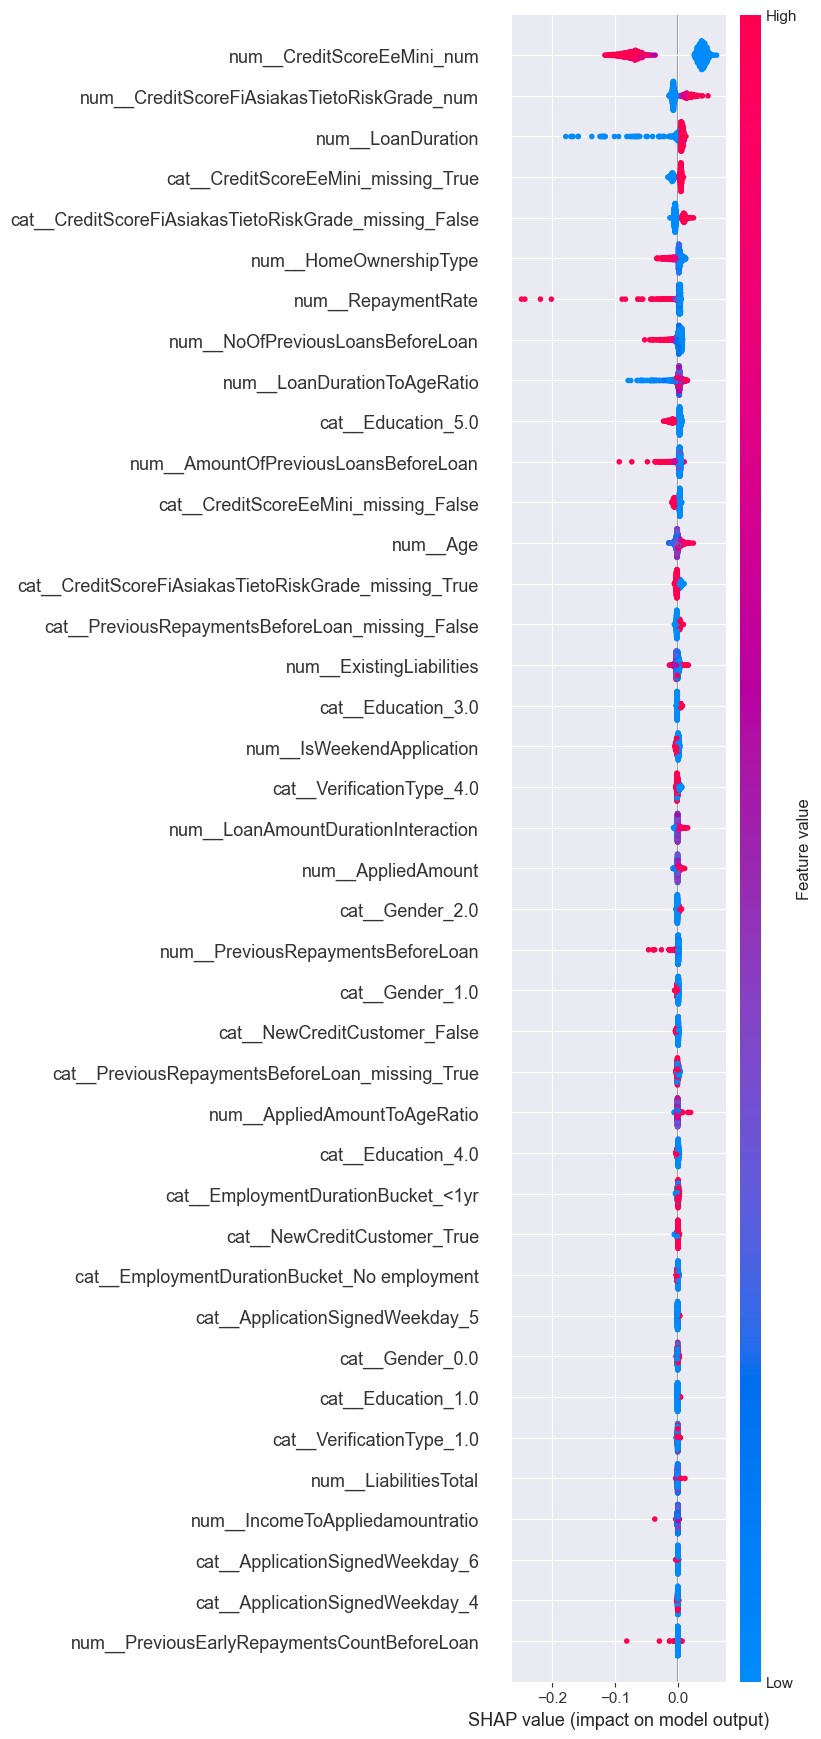

In [13]:
# #SHAP Summary Plot on top 40 features for Robust Model
shap.summary_plot(
    shap_values_robust[:, :, 1], 
    X_test_subset, 
    feature_names=feature_names, 
    max_display=40
)

In [14]:
mean_abs_shap_baseline = np.mean(np.abs(shap_values_baseline.values[:, :, 1]), axis=0)
mean_abs_shap_robust = np.mean(np.abs(shap_values_robust.values[:, :, 1]), axis=0)

print("Mean abs baseline (first 10):", mean_abs_shap_baseline[:10])
print("Mean abs robust (first 10):", mean_abs_shap_robust[:10])


Mean abs baseline (first 10): [0.01021758 0.         0.01138217 0.01211028 0.01140413 0.01092954
 0.         0.0195339  0.0093042  0.02428799]
Mean abs robust (first 10): [0.00285858 0.         0.0051419  0.00115752 0.00840649 0.00210008
 0.         0.00033922 0.00017112 0.00475635]


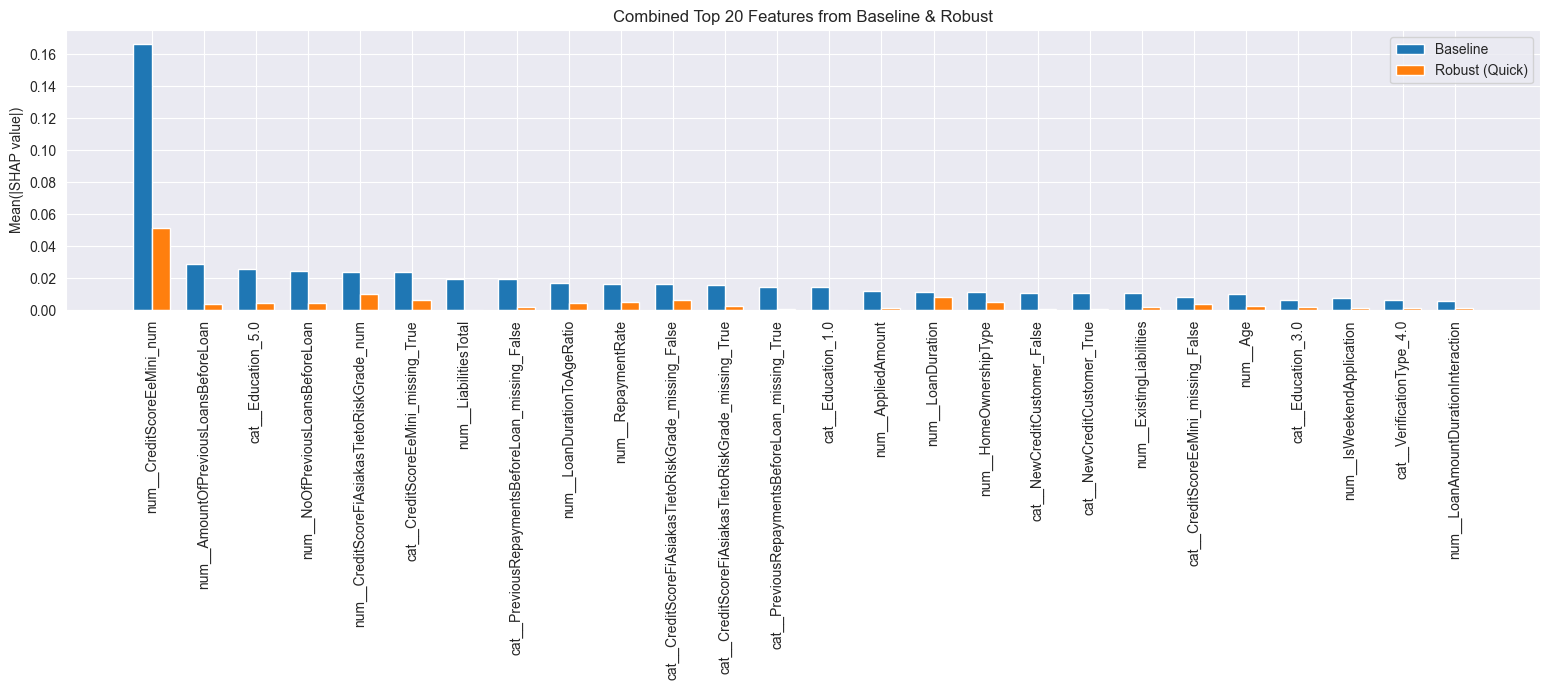

In [15]:

# 1) Get top indices
top_n = 20
sorted_idx_baseline = np.argsort(mean_abs_shap_baseline)[::-1]
sorted_idx_robust = np.argsort(mean_abs_shap_robust)[::-1]

top_features_baseline = sorted_idx_baseline[:top_n]
top_features_robust = sorted_idx_robust[:top_n]

# 2) Combine and deduplicate
combined_features = []
for idx in np.concatenate([top_features_baseline, top_features_robust]):
    if idx not in combined_features:
        combined_features.append(idx)

# 3) Plot
num_features = len(combined_features)
indices = np.arange(num_features)
bar_width = 0.35

baseline_vals = mean_abs_shap_baseline[combined_features]
robust_vals = mean_abs_shap_robust[combined_features]

plt.figure(figsize=(max(12, num_features * 0.6), 7))

plt.bar(indices, baseline_vals, bar_width, label='Baseline')
plt.bar(indices + bar_width, robust_vals, bar_width, label='Robust (Quick)')

plt.xticks(indices + bar_width/2,
           [feature_names[i] for i in combined_features],
           rotation=90)

plt.ylabel('Mean(|SHAP value|)')
plt.title(f'Combined Top {top_n} Features from Baseline & Robust')
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
def predict_with_shap_switch(
    standard_model= baseline_model,
    robust_model = robust_model_quick,
    explainer= explainer,
    X_test = X_test,
    shap_values_train= shap_values_robust.values,
    std_factor=2,
    num_exceeds=10,
    class_index=1
):
    """
    Predict using a hybrid switch:
    - Use standard_model if input looks normal (SHAP within boundary)
    - Use robust_model if input looks suspicious (SHAP deviations too big)

    Parameters:
    - standard_model: your clean, high-accuracy model
    - robust_model: your adversarially trained model
    - explainer: a fitted SHAP explainer for either model
    - X_test: inputs to predict
    - shap_values_train: precomputed SHAP values (train subset) to define boundary
    - std_factor: number of std dev allowed per feature
    - num_exceeds: number of features allowed to exceed threshold
    - class_index: index for target class (default=1 for default/non-default)

    Returns:
    - final_pred: probability prediction array
    - flags: +1 means normal, -1 means suspicious
    """

    # Compute mean + std from clean train SHAP ===
    mean_shap = np.mean(shap_values_train[:, :, class_index], axis=0)
    std_shap = np.std(shap_values_train[:, :, class_index], axis=0)

    # Explain test data ===
    shap_values_test = explainer(X_test)
    shap_test = shap_values_test.values[:, :, class_index]

    # Check SHAP deviation per feature ===
    deviations = np.abs(shap_test - mean_shap)
    thresholds = std_factor * std_shap

    exceeds = deviations > thresholds
    num_exceeds_arr = exceeds.sum(axis=1)

    flags = np.where(num_exceeds_arr > num_exceeds, -1, 1) # if more than num_exceeds features exceed threshold, mark as suspicious

    print(f"Suspicious flags: {np.unique(flags, return_counts=True)}")

    # Get both model predictions ===
    prob_std = scipy.special.softmax(standard_model.predict(X_test), axis=1)
    prob_robust = scipy.special.softmax(robust_model.predict(X_test), axis=1)

    # Switch: normal -> standard, suspicious -> robust ===
    final_pred = np.where(flags.reshape(-1, 1) == 1, prob_std, prob_robust)

    return final_pred, flags

In [17]:
predictions, flags = predict_with_shap_switch(
    standard_model=baseline_model,  
    robust_model=robust_model_quick,
    explainer=explainer,
    X_test=X_test,
    shap_values_train=shap_values_robust.values,
    std_factor=2,
    num_exceeds=10,
    class_index=1
)

PermutationExplainer explainer: 19273it [06:17, 49.58it/s]                           


Suspicious flags: (array([-1,  1]), array([  947, 18325]))
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step


In [18]:
# Suppose your true labels are y_test

# Convert probabilities to predicted classes:
y_final_labels = np.argmax(predictions, axis=1)

y_test_subset = y_test#[:1000]
# Accuracy
acc = accuracy_score(y_test_subset, y_final_labels)
print(f"Accuracy (with SHAP flattening): {acc:.4f}")

# ROC AUC
# For binary, use probability for class 1
auc = roc_auc_score(y_test_subset, predictions[:, 1])
print(f"ROC AUC (with SHAP flattening): {auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test_subset, y_final_labels)
print("Confusion Matrix:")
print(cm)

Accuracy (with SHAP flattening): 0.6445
ROC AUC (with SHAP flattening): 0.6919
Confusion Matrix:
[[3302 5602]
 [1250 9118]]


In [19]:
# Generate BIM adversarial examples
bim = BasicIterativeMethod(estimator=robust_classifier_quick, eps=0.05, max_iter=10)
X_test_bim = bim.generate(x=X_test)

# Run the SHAP switch prediction on BIM adversarial examples
predictions_bim, flags_bim = predict_with_shap_switch(
    standard_model=baseline_model,  
    robust_model=robust_model_quick,
    explainer=explainer,
    X_test=X_test_bim,
    shap_values_train=shap_values_robust.values,
    std_factor=2,
    num_exceeds=10,
    class_index=1
)

PermutationExplainer explainer: 19273it [17:28, 18.12it/s]                              


Suspicious flags: (array([-1,  1]), array([19271,     1]))
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


In [20]:
# Convert probabilities to predicted classes:
y_final_labels = np.argmax(predictions_bim, axis=1)

# Accuracy
acc = accuracy_score(y_test, y_final_labels)
print(f"Accuracy (with SHAP flattening): {acc:.4f}")

# ROC AUC
# For binary, use probability for class 1
auc = roc_auc_score(y_test, predictions_bim[:, 1])
print(f"ROC AUC (with SHAP flattening): {auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_final_labels)
print("Confusion Matrix:")
print(cm)

Accuracy (with SHAP flattening): 0.6225
ROC AUC (with SHAP flattening): 0.6394
Confusion Matrix:
[[2969 5935]
 [1341 9027]]


In [21]:
# Generate BIM adversarial examples
fgm = FastGradientMethod(estimator=robust_classifier_quick, eps=0.05)
X_test_fgm= fgm.generate(x=X_test)

# Run the SHAP switch prediction on BIM adversarial examples
predictions_fgm, flags_fgm = predict_with_shap_switch(
    standard_model=baseline_model,  
    robust_model=robust_model_quick,
    explainer=explainer,
    X_test=X_test_fgm,
    shap_values_train=shap_values_robust.values,
    std_factor=2,
    num_exceeds=10,
    class_index=1
)

PermutationExplainer explainer: 19273it [11:48, 26.83it/s]                           


Suspicious flags: (array([-1,  1]), array([19271,     1]))
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step


In [22]:
# Convert probabilities to predicted classes:
y_final_labels = np.argmax(predictions_fgm, axis=1)


# Accuracy
acc = accuracy_score(y_test, y_final_labels)
print(f"Accuracy (with SHAP flattening): {acc:.4f}")

# ROC AUC
# For binary, use probability for class 1
auc = roc_auc_score(y_test, predictions_fgm[:, 1])
print(f"ROC AUC (with SHAP flattening): {auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_final_labels)
print("Confusion Matrix:")
print(cm)

Accuracy (with SHAP flattening): 0.6227
ROC AUC (with SHAP flattening): 0.6396
Confusion Matrix:
[[2949 5955]
 [1316 9052]]


In [23]:
PGD= ProjectedGradientDescent(
    estimator=robust_classifier_quick,
    eps=0.05,
    eps_step=0.01,
    max_iter=10,
)
x_test_pgd = PGD.generate(x=X_test)
# Run the SHAP switch prediction on PGD adversarial examples
predictions_pgd, flags_pgd = predict_with_shap_switch(
    standard_model=baseline_model,  
    robust_model=robust_model_quick,
    explainer=explainer,
    X_test=x_test_pgd,
    shap_values_train=shap_values_robust.values,
    std_factor=2,
    num_exceeds=10,
    class_index=1   
)


PermutationExplainer explainer: 19273it [10:28, 30.15it/s]                           


Suspicious flags: (array([-1,  1]), array([19271,     1]))
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step


In [24]:
# Convert probabilities to predicted classes:
y_final_labels = np.argmax(predictions_pgd, axis=1)


# Accuracy
acc = accuracy_score(y_test, y_final_labels)
print(f"Accuracy (with SHAP flattening): {acc:.4f}")

# ROC AUC
# For binary, use probability for class 1
auc = roc_auc_score(y_test, predictions_pgd[:, 1])
print(f"ROC AUC (with SHAP flattening): {auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_final_labels)
print("Confusion Matrix:")
print(cm)

Accuracy (with SHAP flattening): 0.6206
ROC AUC (with SHAP flattening): 0.6393
Confusion Matrix:
[[2918 5986]
 [1326 9042]]
